<a href="https://colab.research.google.com/github/lightucha/how-to-opencv/blob/main/opencv_210831.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 패캠 openCV ch08 Review
- 영상 분할과 객체 검출

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print(cv2.__version__)

4.1.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpath = '/content/drive/MyDrive/1.Project/{PATH}/'

### 그랩컷(GrabCut)
- 그래프 컷(graph cut) 기반 영역 분할 알고리즘
- 픽셀들을 두 개의 그룹(객체 그룹, 배경 그룹)으로 분할하는 최적의 컷(Max Flow Minimum Cut)을 찾는 방식

??

<b>cv2.grabCut(img, mask, rect, bgdModel, fgdmodel, iterCount, mode=None) -> mask, bgdModel, fgdModel</b>

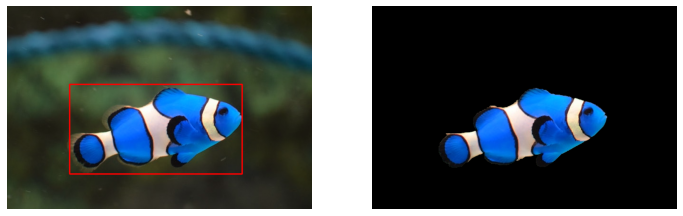

In [ ]:
# 입력 영상 불러오기
src = cv2.imread(gpath + 'ch08/nemo.jpg')

# 사장형 지정을 통한 초기 분할
# rc = cv2.selectROI(src) # 초기 위치 지정하고 모서리 좌표 4개를 튜플값으로 반환
# 물고기 좌표 - 로컬 체크
rc = (131, 164, 363, 189)
mask = np.zeros(src.shape[:2], np.uint8) # 마스크는 검정색으로 채워져있고 입력 영상과 동일한 크기

# 결과를 계속 업데이트 하고 싶으면 bgd, fgd 입력
cv2.grabCut(src, mask, rc, None, None, 5, cv2.GC_INIT_WITH_RECT)

# grabCut 자료에서 0,2는 배경, 1,3은 전경입니다.
# mask == 0 or mask == 2를 만족하면 0으로 설정 아니면 1로 설정합니다
mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')

# np.newaxis로 차원 확장
dst = src * mask2[:, :, np.newaxis]
cv2.rectangle(src, rc, (255,0,0), 2)

plt.figure(figsize=(12,8))
plt.subplot(121); plt.imshow(src, cmap='gray'); plt.axis('off')
plt.subplot(122); plt.imshow(dst, cmap='gray'); plt.axis('off')
plt.show()

### 모멘트 기반 객체 검출
영상의 형태를 표현하는 일련의 실수값
- Geometric moments, Central moments, Normalized central moments, Legendre moments, Complex moments, Zernike moments, ART(Angular Radial Transform), etc.
- Image Moment는 대상을 구분할 수 있는 특징을 의미
 - 특징으로는 Area, Perimeter, 중심점 등이 있음. 
 - Image Moments는 대상을 구분한 후, 다른 대상과 구분하기 위해 대상을 설명(describe)하는 자료

(참고) 모멘트?
- In physics, a moment is an expression involving the product of a distance and another physical quantity, and in this way it accounts for how the physical quantity is located or arranged. (출처: 위키피디어 https://en.wikipedia.org/wiki/Moment_(physics))
-  거리와 다른 물리량의 프러덕트(벡터 연산중 프러덕트, ×, 즉 벡터곱)를 포함하는 식이고, 이런 방식으로 물리량이 어떻게 자리잡고 있는지 혹은 배열되어 있는지 설명

<b>cv2.matchShapes(contour1, contour2, method, parameter) -> retval</b>
- method: 비교 방법 지정
 - cv2.CONTOUR_MATCH_I3(정규화)를 많이 사용
- retval: 두 외곽선 또는 그레이스케일 영상 사이의 거리(distance)
 - <u><b>어떤 두 객체가 비슷하다고 판단하면 작은 값, 다르다고 판단하면 큰 값을 반환</b></u>
- 참고: Hu의 불변모멘트를 이용하여 두 외곽선 또는 영상의 모양을 비교
 - Hu 불변 모멘트: 3차 이하의 정규화된 중심 모멘트를 조합하여 만든 7개 모멘트 값

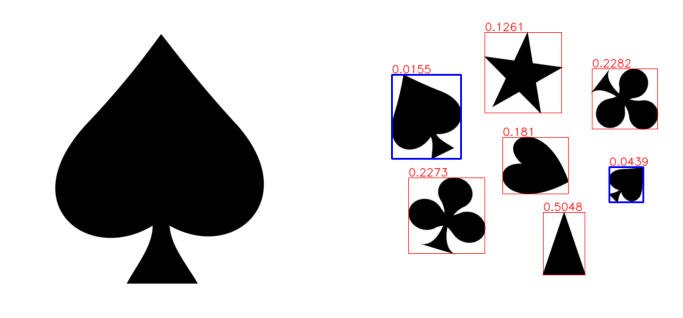

In [ ]:
# 영상 불러오기
# 2장의 영상을 사용합니다.
# 객체가 검은색, 배경이 흰색이라 findcontour을 이용할 때 반전해서 이용해야 합니다.
# symbols 에서 spades를 찾아내는 것이 목적입니다.
obj = cv2.imread(gpath + 'ch08/spades.png', cv2.IMREAD_GRAYSCALE) # 찾고 싶은거
src = cv2.imread(gpath + 'ch08/symbols.png', cv2.IMREAD_GRAYSCALE) # 대상

# plt.figure()
# plt.subplot(121); plt.imshow(obj, cmap='gray')
# plt.subplot(122); plt.imshow(src, cmap='gray')
# plt.show()

# 객체 영상 외곽선 검출
# 이진화, 반전
_, obj_bin = cv2.threshold(obj, 128, 255, cv2.THRESH_BINARY_INV) # return: 임계값, 영상

# plt.figure()
# plt.imshow(obj_bin, cmap='gray')
# plt.show()

# 외곽선 검출, EXTERNAL은 바깥 윤곽선, APPROX_NONE는 모든 외곽선 좌표 구하기
obj_contours, _ = cv2.findContours(obj_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # return: 외곽선 좌표, 계층

# 외곽선 정보를 obj_pts에 저장 (객체 1개)
obj_pts = obj_contours[0]

# 입력 영상 분석
# src 영상에서 객체가 검은색이므로 반전해서 이진화
_, src_bin = cv2.threshold(src, 128, 255, cv2.THRESH_BINARY_INV)

# plt.figure()
# plt.imshow(src_bin, cmap='gray')
# plt.show()

# 모든 정보를 저장
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 결과 영상
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

# 입력 영상의 모든 객체 영역에 대해서 contours에 있는 각각의 점들의 집합을 검출
for pts in contours:
    if cv2.contourArea(pts) < 1000: # 영역 계산, 노이즈 제거
        continue
        
    # 외곽선 사각형 좌표 받아서 그리기
    rc = cv2.boundingRect(pts) # 외곽선 좌표 입력하면 사각형 좌표 반환
    cv2.rectangle(dst, rc, (255, 0, 0), 1)
    
    # 두 개의 외곽선 정보를 비교해서 모양을 비교하는 용도로 사용
    # 이미 변형이 생긴 모양을 비교할 때는 동작이 잘 안됌
    # 기본적으로 회전, 크기 변환, 대칭, 이동
    dist = cv2.matchShapes(obj_pts, pts, cv2.CONTOURS_MATCH_I3, 0)
    
    # distance 값을 화면에 출력
    # spades와 같은 모양은 0.1보다 작은값
    cv2.putText(dst, str(round(dist, 4)), (rc[0], rc[1] - 3),
    			cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1, cv2.LINE_AA)
    
    # 0.1 보다 작은 건 파란색으로 사각형
    if dist < 0.1:
        cv2.rectangle(dst, rc, (0, 0, 255), 2)

plt.figure(figsize=(12,8))
plt.subplot(121); plt.imshow(obj, cmap='gray'); plt.axis('off')
plt.subplot(122); plt.imshow(dst, cmap='gray'); plt.axis('off')
plt.show()

### 템플릿 매칭(Template matching): 이해하기
- 입력 영상에서 템플릿 영상과 일치하는 부분을 찾는 기법
- 템플릿: 찾을 대상이 되는 작은 영상, 패치(patch)

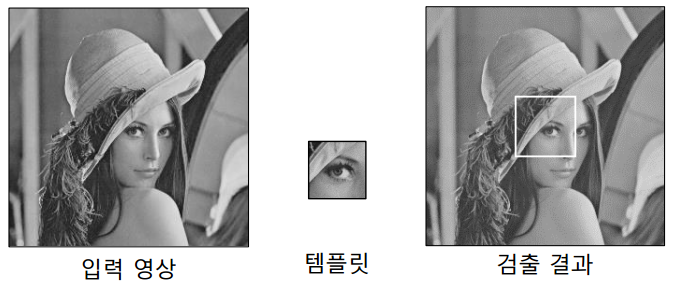

템플릿 동작 방식
- 전체 영역을 스캔
- 템플릿 영상과 입력 영상 간 유사도와 비유사도를 실수 형태의 행렬로 반환(거리 개념)

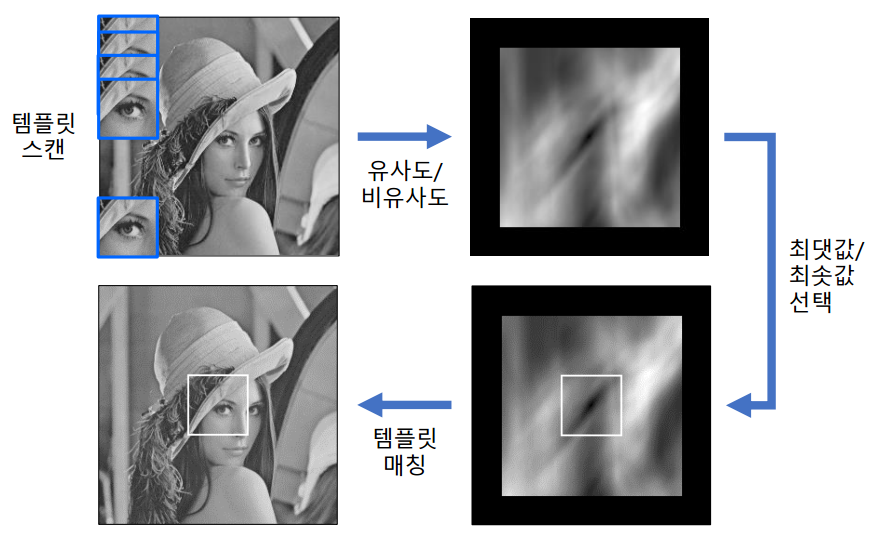

<b>cv2.matchTemplage(img, templ, method, result=None, mask=None) -> result</b>
- img: 입력 영상(8비트 or 32비트)
- method: 비교 방법(cv2.TM_ flag code)
- mask: 입력 영상 전체에서 템플릿 매칭할지, 일부분에서만 템플릿 매칭할지 결정
- result: 비교 결과 행렬
 - img 크기: W x H
 - templ 크기: w x h
 - result 크기: (W-w+1) x (H-h+1)
  - 필터링이 동작할 때, 영상의 가장자리에 가상의 픽셀 가정 -> 동일한 크기 영상 출력
  - 템플릿 매칭은 동작할 때, 가상의 픽셀을 가정하지 않음 -> 입력 영상보다 한 픽셀 작은 형태

템플릿 매칭 method
1. cv2.TM_SQDIFF: 유사하면 0(검은색), 다르면 255(검은색)

 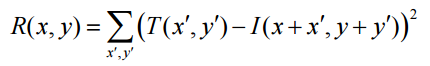



2. cv2.TM_SQDIFF_NORMED: SQDIFF를 [0,1]로 정규화

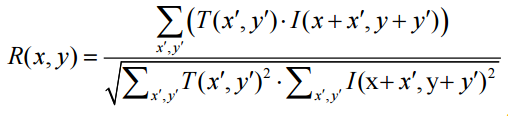

3. cv2.TM_CCORR: 유사할 수록 큰 값(255), 다르면 작은 값(0)
 - 원본 영상의 흰색 부분은 결과값이 크게 나오는 경향이 있음
 - 밝기를 보정하던가 정규화하는 방법으로 해결

 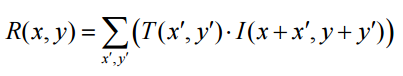 

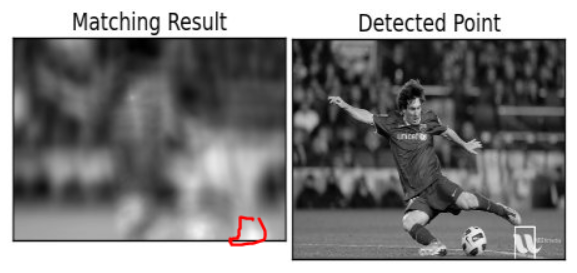

4. cv2.TM_CCORR_NORMED: CCORR을 [0, 1]로 정규화한 것

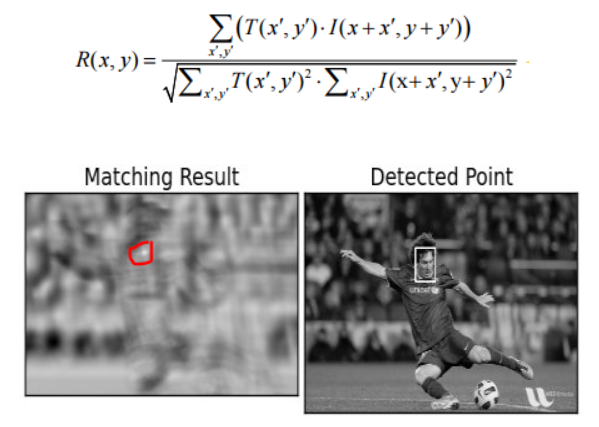

5. cv2.TM_CCOEFF: 밝기를 보정하고 CCORR방법을 이용
 - $T'$: 템플릿 영상의 평균값으로 뺀 값
 - 밝기 보정으로 더 나은 결과 출력

 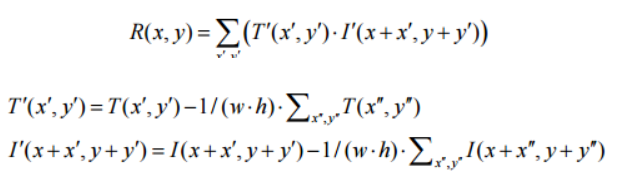

6. cv2.TM_CCOEFF_NORMED: 완전히 일치하면 1, 역일치하면 -1, 상호 연관성이 없으면 0
 - 가장 성능이 뛰어나지만 수식이 복잡해서 연산량 많음

 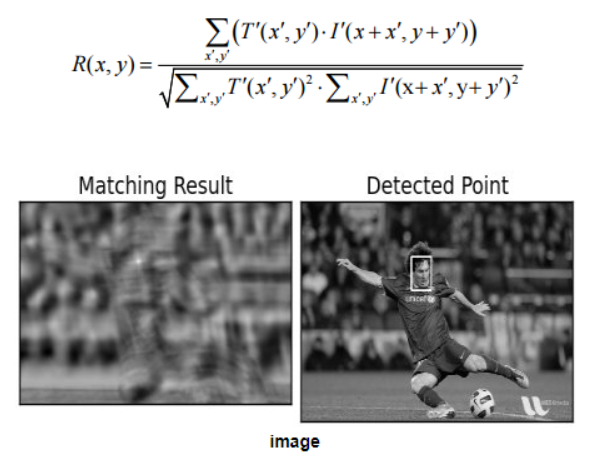

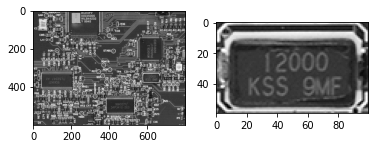

maxv :  0.979878306388855
maxloc :  (568, 320)


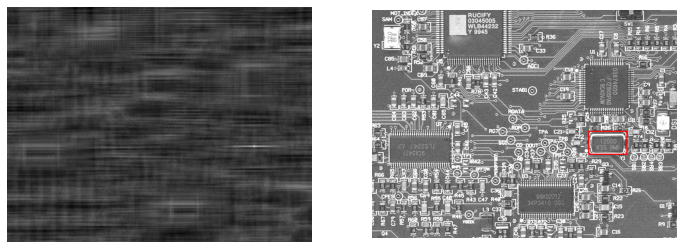

In [ ]:
# 입력 영상 & 템플릿 영상 불러오기
src = cv2.imread(gpath + 'ch08/circuit.bmp', cv2.IMREAD_GRAYSCALE)
templ = cv2.imread(gpath + 'ch08/crystal.bmp', cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.subplot(121); plt.imshow(src, cmap='gray')
plt.subplot(122); plt.imshow(templ, cmap='gray')
plt.show()

# 입력 영상 밝기 50증가, 가우시안 잡음(sigma=10) 추가하여 약간의 변형을 줌
noise = np.zeros(src.shape, np.int32)

# cv2.randn은 가우시안 형태의 랜덤 넘버를 지정, 노이즈 영상에 평균이 50 시그마 10인 노이즈 추가
cv2.randn(noise,50,10)

# 노이즈를 입력 영상에 더함, 원래 영상보다 50정도 밝아지고 시그마 10정도 변형
src = cv2.add(src, noise, dtype=cv2.CV_8UC3)

# 탬플릿 매칭 & 결과 분석
res = cv2.matchTemplate(src, templ, cv2.TM_CCOEFF_NORMED) # 여기서 최댓값 찾기

# 최솟값 0, 최댓값 255 지정하여 결과값을 그레이스케일 영상으로 만들기
res_norm = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# 최댓값을 찾아야하므로 minmaxloc 사용, min, max, min좌표, max좌표 반환
_, maxv, _, maxloc = cv2.minMaxLoc(res)

# 탬플릿에 해당하는 영상이 입력 영상에 없으면 고만고만한 값에서 가장 큰 값을 도출.
# 그래서 maxv를 임계값 0.7 or 0.6을 설정하여 템플릿 영상이 입력 영상에 존재하는지 파악
print('maxv : ', maxv)
print('maxloc : ', maxloc) 

# 매칭 결과를 빨간색 사각형으로 표시
# maxv가 어느 값 이상이여야지 잘 찾았다고 간주할 수 있다.
th, tw = templ.shape[:2]
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
cv2.rectangle(dst, maxloc, (maxloc[0] + tw, maxloc[1] + th), (255, 0, 0), 2)

# 결과 영상 화면 출력
plt.figure(figsize=(12, 8))
plt.subplot(121); plt.imshow(res_norm, cmap='gray'); plt.axis('off')
plt.subplot(122); plt.imshow(dst, cmap='gray'); plt.axis('off')
plt.show()

### 템플릿 매칭 (2): 인쇄체 숫자 인식
- 인식(Recognition)이란?
 - 여러 개의 클래스 중에서 가장 유사한 클래스를 선택

 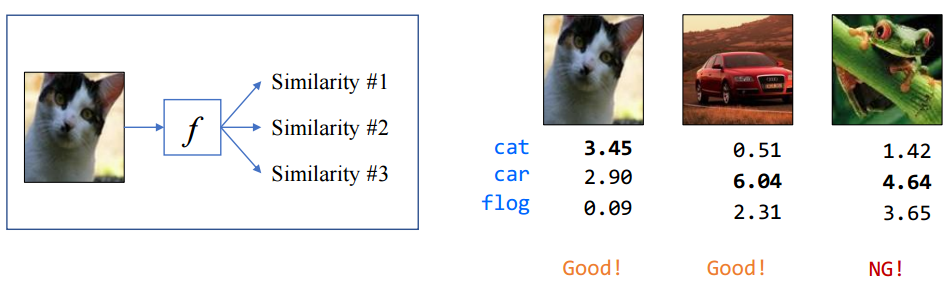

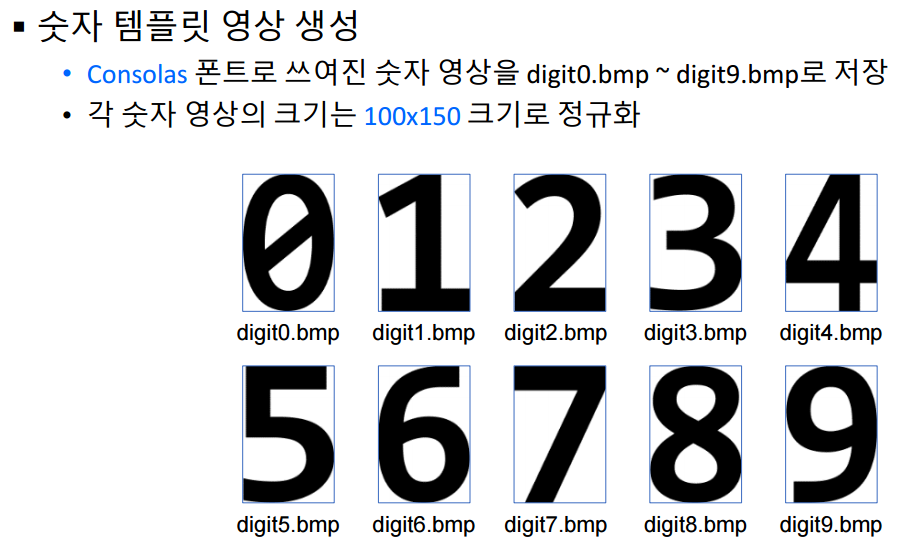

NCC: Normalized Cross Correlation
- 원본 영상과 찾고자 하는 영상 간 유사도

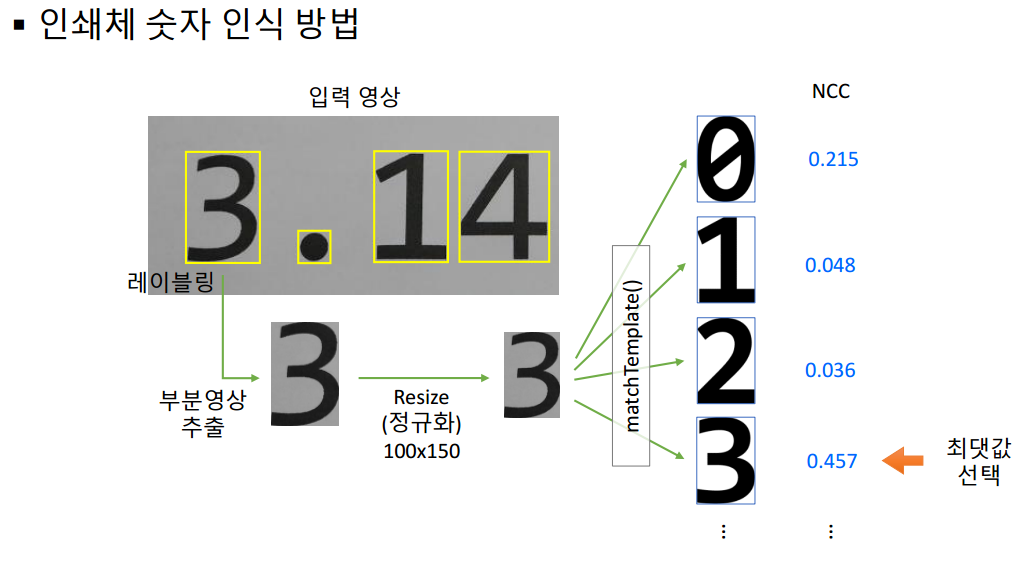

10


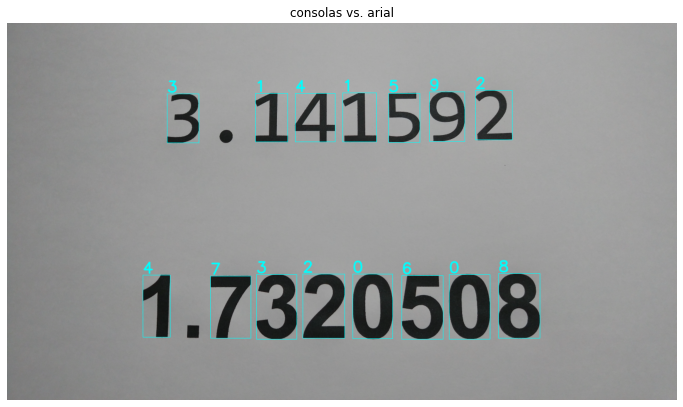

In [ ]:
def load_digits():
    img_digits = []

    for i in range(10):
        filename = gpath + 'ch08/digits/digit{}.bmp'.format(i)
        img_digits.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))

        if img_digits[i] is None:
            return None

    return img_digits


def find_digit(img, img_digits):
    max_idx = -1
    max_ccoeff = -1

    # 최대 NCC 찾기
    for i in range(10):
        img = cv2.resize(img, (100, 150))
        res = cv2.matchTemplate(img, img_digits[i], cv2.TM_CCOEFF_NORMED)

        if res[0, 0] > max_ccoeff:
            max_idx = i
            max_ccoeff = res[0, 0]

    return max_idx



# 입력 영상 불러오기
src = cv2.imread(gpath+'ch08/digits_print.bmp')

# 100x150 숫자 영상 불러오기
img_digits = load_digits()  # list of ndarray
print(len(img_digits))

# 입력 영상 이진화 & 레이블링
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
_, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
cnt, _, stats, _ = cv2.connectedComponentsWithStats(src_bin)

# 숫자 인식 결과 영상 생성
dst = src.copy()
for i in range(1, cnt):
    (x, y, w, h, s) = stats[i]

    if s < 1000:
        continue

    # 가장 유사한 숫자 이미지를 선택
    digit = find_digit(src_gray[y:y+h, x:x+w], img_digits)
    cv2.rectangle(dst, (x, y, w, h), (0, 255, 255))
    cv2.putText(dst, str(digit), (x, y - 4), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 255), 2, cv2.LINE_AA)

# 결과 출력
plt.figure(figsize=(12, 8))
plt.imshow(dst, cmap='gray'); plt.axis('off'); plt.title('consolas vs. arial')
plt.show()

### 캐스케이드 분류기: 얼굴 검출
- 캐스케이드는 직렬로 연결되어 있음을 의미
- 얼굴 검출 용도로 많이 사용
 - 눈, 보행자, 자동차 번호판까지 검출 가능

Viola - Jones 얼굴 검출기 <p>
Positive 영상(얼굴)과 Negative 영상(얼굴 아닌 영상)을 학습하여 얼굴 영역 검출
- AdaBoost 기반(강한 분류 성능)
- 유사 하르(haar-like) 특징을 사용
- 캐스케이드(cascade) 방식 -> 빠른 동작 속도
 - 기존 얼굴 검출 방법보다 약 15배 빠르게 동작

유사 하르 특징(Haar-like features) <p>
검정색과 흰색으로 구성된 사각형 형태의 필터 마스크 이용
- 흰색 영역 필셀 값의 합에서 검정색 영역 픽셀 값을 뺀 결과값을 추출

음영 특징을 통해서 분류기 작동
- 대부분 눈쪽은 어둡고 눈 아래쪽은 밝게 나옴
- 눈 사이는 밝고 눈 부분은 어둡게 나옴

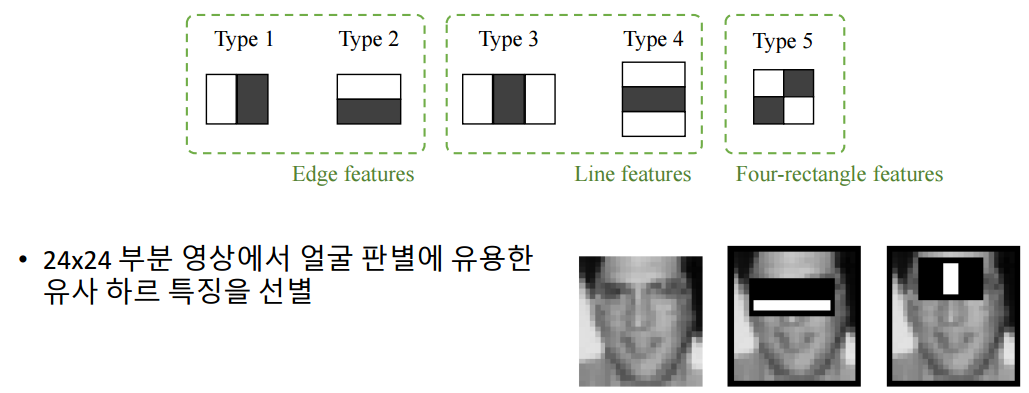

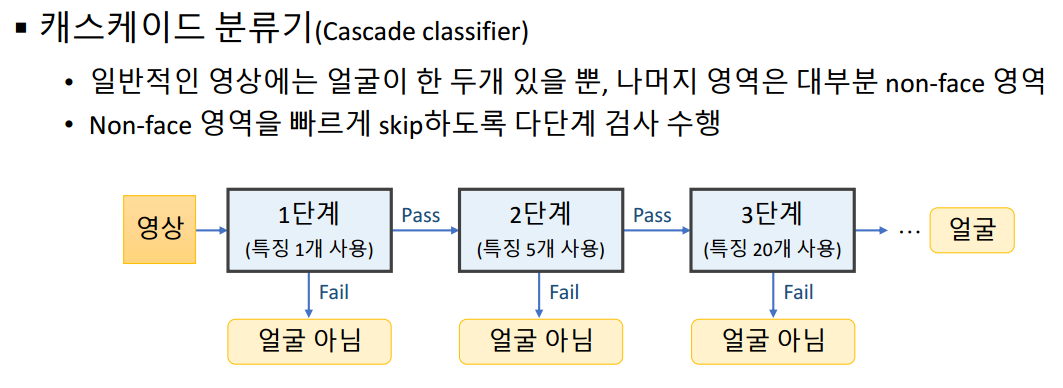

캐스케이드 분류기 얼굴 검출 과정
- 박스가 얼굴을 지나갈 때 얼굴뿐만 아니라 좌우위아래 1~2 픽셀 떨어진 곳도 마킹
- 얼굴 근방에 박스가 3개 이상 되어야 얼굴로 판단


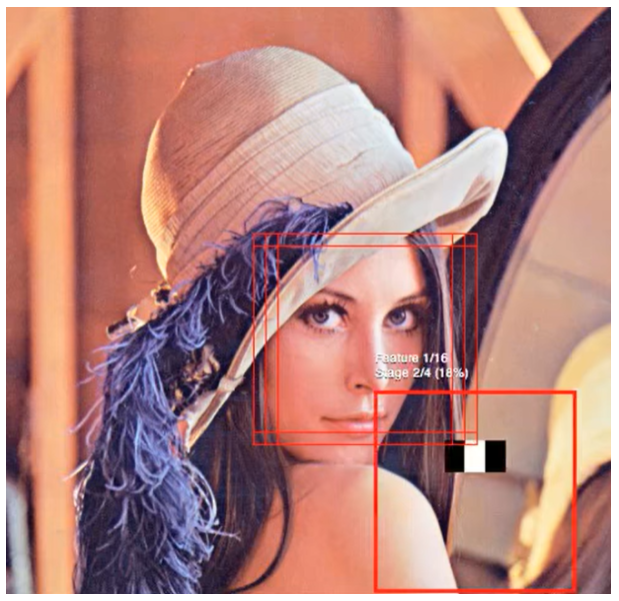


<b>cv2.CascadeClassifier()</b> or
<b>cv2.CascadeClassifier(filename)</b>
- filename: XML 파일 이름
 - filename 미지정 시: cv2.CascadeClassifier.load(filename)

<b>cv2.CascadeClassifier.detectMultiScale(img, scaleFactor=None, minNeighbors=None, flags=None, minSize=None, maxSize=None)</b>
- img: 입력 영상(cv2.CV_8U)
- minNeighbors: 얼마나 많은 이웃 사각형이 검출되어야 최종 검출 영역으로 설정할지를 지정(기본값은 3)
- minSize: 최소 객체 크기. (w, h) 튜플
- maxSize: 최대 객체 크기. (w, h) 튜플

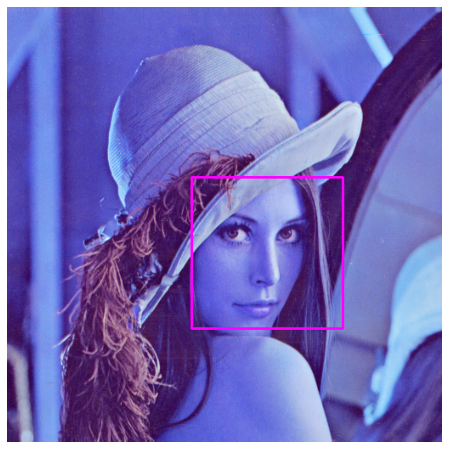

In [ ]:
src = cv2.imread(gpath+'ch08/lenna.bmp', cv2.COLOR_BGR2RGB)

# 객체 생성
# 미리 학습된 XML 파일 다운로드 github
# github.com/opencv/opencv/tree/master/data/haarcascades
classifier = cv2.CascadeClassifier(gpath+ 'haarcascade_frontalface_alt2.xml')

# 입력영상에서 얼굴을 검출
faces = classifier.detectMultiScale(src) # 스케일팩터를 1.2로 지정해도 잘 작동함 더 빨라짐

# 각각의 행마다 (x,y,w,h) 받아와서 사각형을 그리는 코드
for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)

plt.figure(figsize=(12,8))
plt.imshow(src, cmap='gray'); plt.axis('off')
plt.show()

uint8


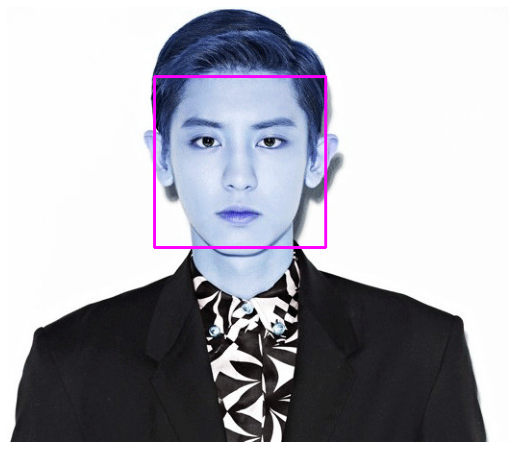

In [ ]:
src = cv2.imread(gpath+'google_sample.jpg')
print(src.dtype)

# 입력영상에서 얼굴을 검출
faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)

plt.figure(figsize=(12,8))
plt.imshow(src, cmap='gray'); plt.axis('off')
plt.show()

캐스케이드 분류기를 이용해서 얼굴 검출하는 것을 추천하지는 않음!!
- 얼굴이 가려지면 검출을 잘 못한다고 함...
- 딥러닝 기반(싱글샷 디텍터: SSD, YOLO)가 더 정확하고 속도가 빠름

uint8


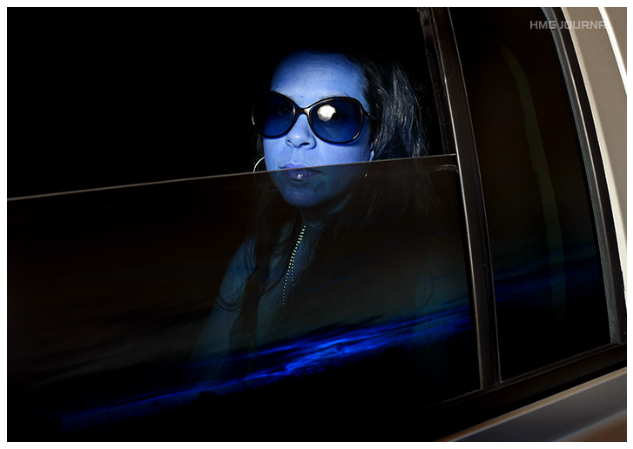

In [ ]:
src = cv2.imread(gpath+'window-tinting.jpg', cv2.COLOR_BGR2RGB)
print(src.dtype)

# 입력영상에서 얼굴을 검출
faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)

plt.figure(figsize=(12,8))
plt.imshow(src, cmap='gray'); plt.axis('off')
plt.show()

### HOG 보행자 검출
HOG(Histogram of Oriented Gradients)란?
전체 영상에서 부분 영상을 추출 후, 부분 영상의 특징을 추출하여 전신을 판단하는 알고리즘
- 영상의 지역적 그래디언트 방향 정보를 특징 벡터로 사용
- 보행자 검출 방법으로 소개되어 널리 사용
- 다양한 객체 인식에서 활용

<b>작동 순서</b>

(1) 임의의 크기의 사각형을 정의해서 부분 영상을 추출

(2) 추출한 부분 영상의 크기를 정규화(64x128)

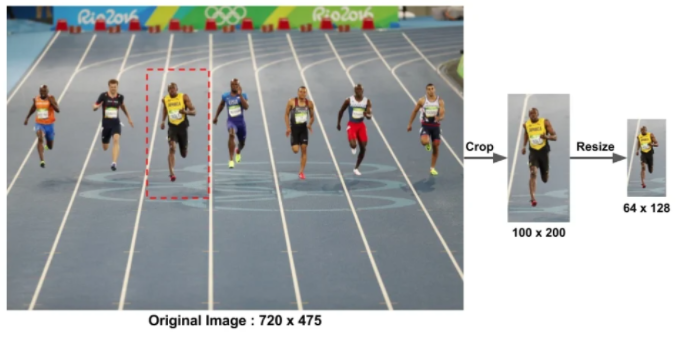

(3) 64x128 영상의 그래디언트를 계산하여 방향 성분과 크기 성분을 파악

(4) 64x128 영상을 8x8 크기의 셀(cell)로 분할

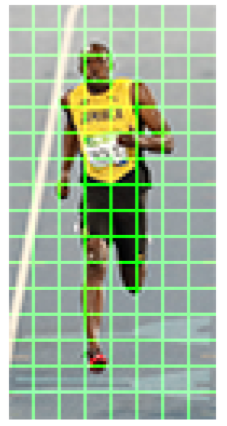

(5) 각 셀마다 방향과 크기 성분을 이용하여 방향 히스토그램 계산

(6) 각각의 셀에서 방향 성분을 9개로 구분하여 9가지 방향에 대한 히스토그램 생성
- 180도를 20도씩 9가지 방향, 대칭하면 360도)

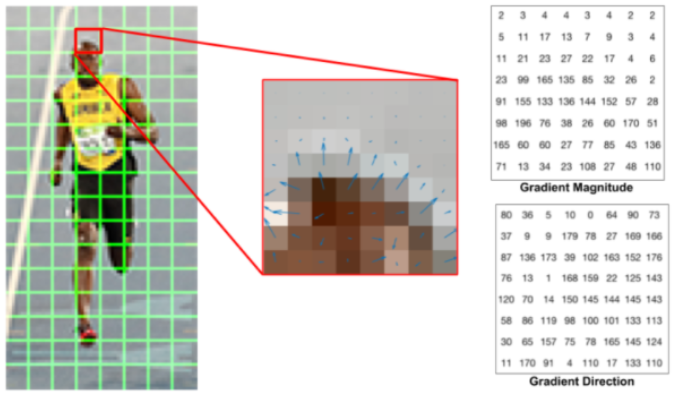

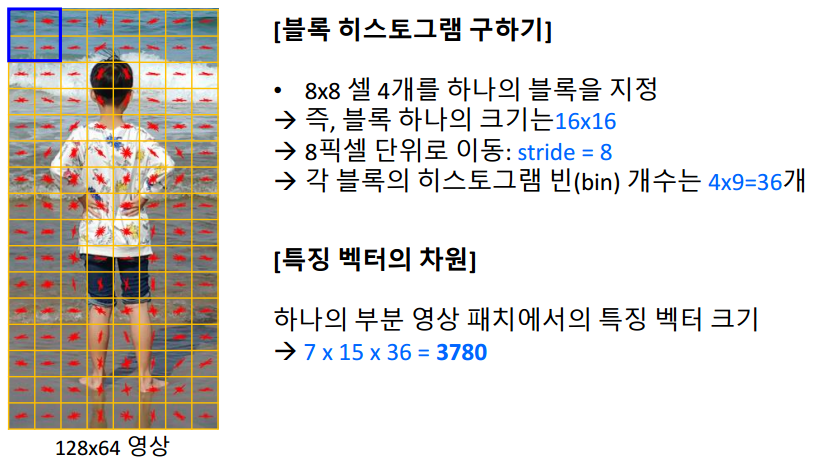

source: https://www.koreascience.or.kr/article/CFKO201531751956358.pdf

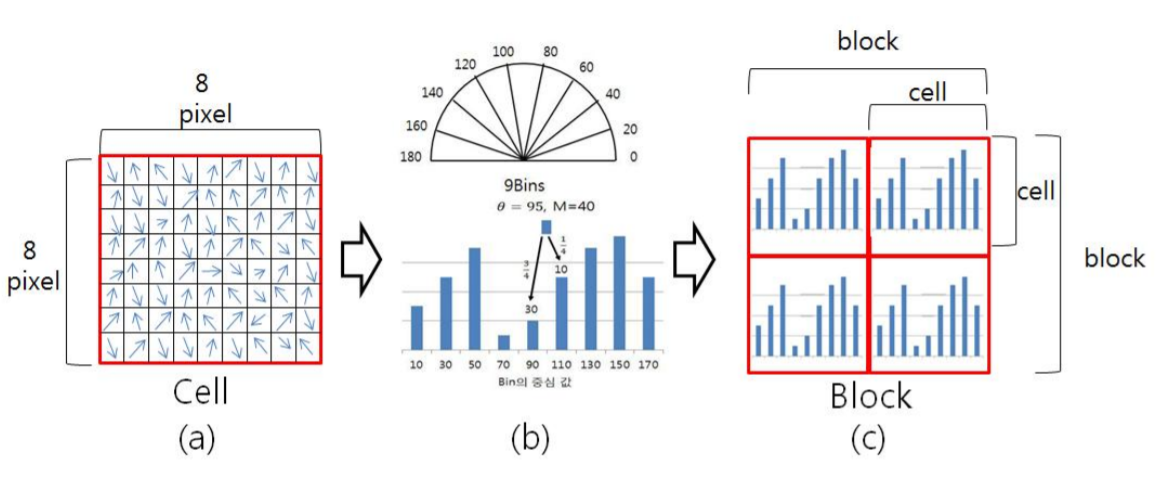

<b>(1) cv2.HOGDescriptor()</b>

<b>(2) cv2.HOGDescriptor_getDefaultPeopleDetector() -> retval</b>
- retval: pre-trained 특징 벡터(opencv 내부 저장)

<b>(3) cv2.HOGDescriptor.setSVMDetector(svmdetector)</b>
- svmdetector: 선형 SVM 분류기를 위한 계수

_HOG 멀티스케일 객체 검출 함수_

<b>(4) cv2.HOGDescriptor.detectMultiScale(img, hitThreshold=None, winStride=None, padding=None, scale=None, finalThreshold=None, useMeanshiftGrouping=None) -> foundLocations, foundWeights</b>
- hitThreshold: 특징 벡터와 SVM 분류 평면까지의 거리에 대한 임계값
- winStride: 셀 윈도우 이동 크기. (0, 0) 지정 시 셀 크기와 같게 설정.
- padding: 패딩 크기
- finalThreshold: 검출 결정을 위한 임계값
- foundLocations: (출력) 검출된 사각형 영역 정보
- foundWeights: (출력) 검출된 사각형 영역에 대한 신뢰도


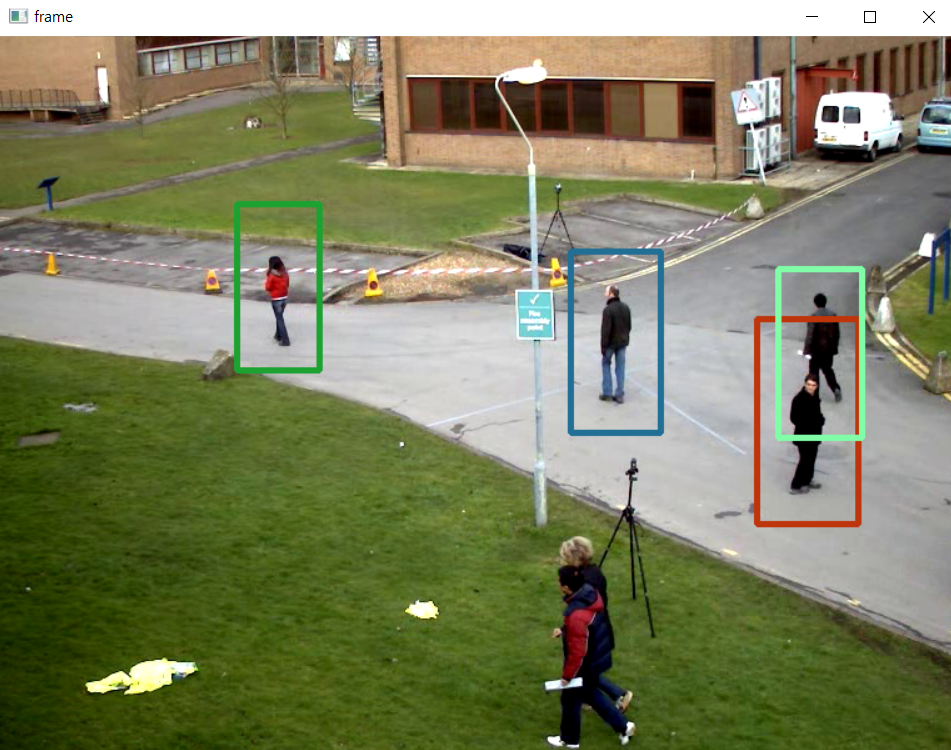